In [ ]:
!pip install ucimlrepo shap lifelines plotly

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ecd071e0220becc39ea200e104f1ac759580b2861a949da4ee7f5e81d753250b
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from ucimlrepo import fetch_ucirepo

# ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Survival
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Explainability
import shap

In [ ]:
dataset = fetch_ucirepo(id=565)

X_raw = dataset.data.features.copy()
y_raw = dataset.data.targets.copy()

df = pd.concat([X_raw, y_raw], axis=1)
df.head()


,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1,1,22.830137,0,1,0,1,1.0,1.0,0.0,...,1.0,7.20,1.338760,5.38,35.0,19,51,32,999,0
1,1,0,23.342466,0,1,0,-1,-1.0,1.0,0.0,...,1.0,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
2,1,0,26.394521,0,1,0,-1,-1.0,1.0,0.0,...,1.0,7.94,19.013230,0.42,23.4,23,20,1000000,435,1
3,0,0,39.684932,1,1,0,1,2.0,1.0,1.0,...,NaN,4.25,29.481647,0.14,50.0,23,29,19,53,1
4,0,1,33.358904,0,0,0,1,2.0,0.0,1.0,...,1.0,51.85,3.972255,13.05,9.0,14,14,1000000,2043,0


In [ ]:
y = df["survival_status"].astype(int).values   # 0 = alive, 1 = dead
time = df["survival_time"].values              # days

In [ ]:
PRE_TX = [
    "Recipientage", "Recipientgender", "Rbodymass",
    "Diseasegroup", "Riskgroup", "ABOmatch",
    "Donorage", "Stemcellsource", "CD34kgx10d6"
]

POST_TX_NO_GVHD = PRE_TX + [
    "ANCrecovery", "PLTrecovery",
    "CD3dkgx10d8", "CD3dCD34"
]

POST_TX_FULL = POST_TX_NO_GVHD + [
    "IIIV", "aGvHDIIIIV",
    "extcGvHD", "time_to_aGvHD_III_IV"
]

In [ ]:
df_model = df.copy()

for col in PRE_TX + POST_TX_FULL:
    if df_model[col].dtype != "object":
        df_model[col].fillna(df_model[col].median(), inplace=True)
    else:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)


/tmp/ipython-input-1249945205.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(df_model[col].median(), inplace=True)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve
)


def evaluate_model(
    name,
    model,
    X_train,
    X_test,
    y_train,
    y_test,
    plot=True
):
    # ---- Train model ----
    model.fit(X_train, y_train)

    # ---- Predictions ----
    prob = model.predict_proba(X_test)[:, 1]
    pred = model.predict(X_test)

    # ---- Metrics ----
    auc = roc_auc_score(y_test, prob)
    acc = accuracy_score(y_test, pred)

    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    cm = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)  # Recall
    specificity = tn / (tn + fp)

    # ---- Plotting ----
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Confusion Matrix
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
            ax=axes[0]
        )
        axes[0].set_title(f"{name} - Confusion Matrix")
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Actual")

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, prob)
        axes[1].plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        axes[1].plot([0, 1], [0, 1], linestyle="--")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title(f"{name} - ROC Curve")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    # ---- Return everything ----
    return {
        "name": name,
        "model": model,
        "prob": prob,
        "pred": pred,
        "auc": auc,
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm
    }


In [ ]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        class_weight="balanced",
        max_iter=5000
    ))
])


In [ ]:
rf = RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)


In [ ]:
from sklearn.model_selection import train_test_split
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(df_model[PRE_TX], y, test_size=0.3)
X_train_post, X_test_post, y_train_post, y_test_post = train_test_split(df_model[POST_TX_FULL], y, test_size=0.3)
X_train_nogvhd, X_test_nogvhd, y_train_nogvhd, y_test_nogvhd = train_test_split(df_model[POST_TX_NO_GVHD], y, test_size=0.3)

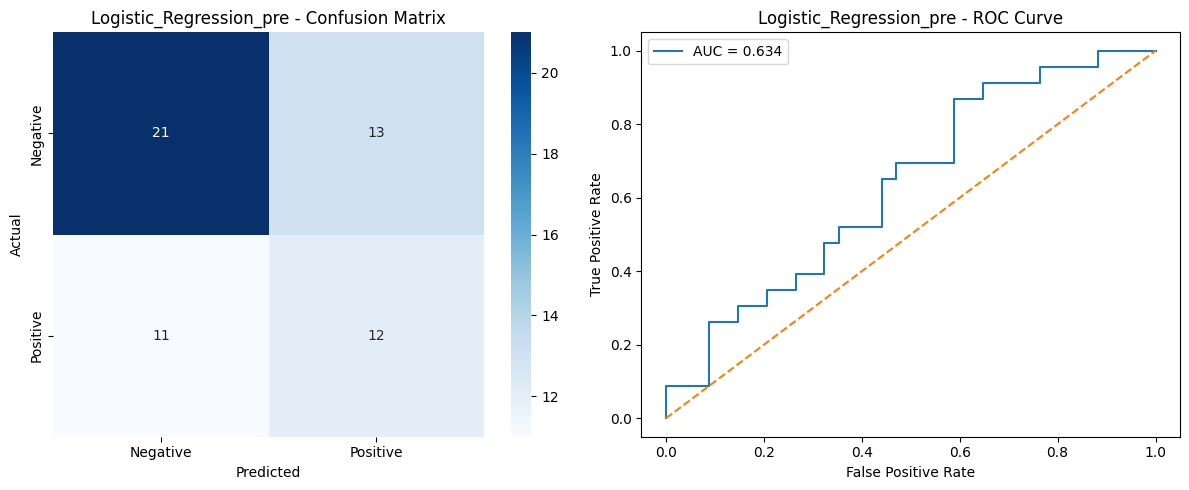

{'name': 'Logistic_Regression_pre',
 'model': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                     max_iter=5000, penalty='elasticnet',
                                     solver='saga'))]),
 'prob': array([0.28050111, 0.72597647, 0.29372812, 0.82883534, 0.38918238,
        0.42578286, 0.3136953 , 0.41474174, 0.27341037, 0.6737245 ,
        0.45276169, 0.30779896, 0.84856272, 0.34740418, 0.40360901,
        0.64674591, 0.62181741, 0.36606976, 0.72328643, 0.22995476,
        0.56788674, 0.30185729, 0.24390216, 0.42691275, 0.62529001,
        0.56353358, 0.37428207, 0.63424829, 0.27315985, 0.31154037,
        0.51054417, 0.59085402, 0.31379593, 0.3871651 , 0.57519218,
        0.33564018, 0.39697503, 0.55353726, 0.72714934, 0.76606439,
        0.40666146, 0.29189672, 0.69657035, 0.68323605, 0.79822264,
        0.30460285, 0.44757114, 0.57529487, 0.73032191, 0

In [ ]:
evaluate_model(
    'Logistic_Regression_pre',
    log_reg,
    X_train_pre,
    X_test_pre,
    y_train_pre,
    y_test_pre,
    plot=True
)

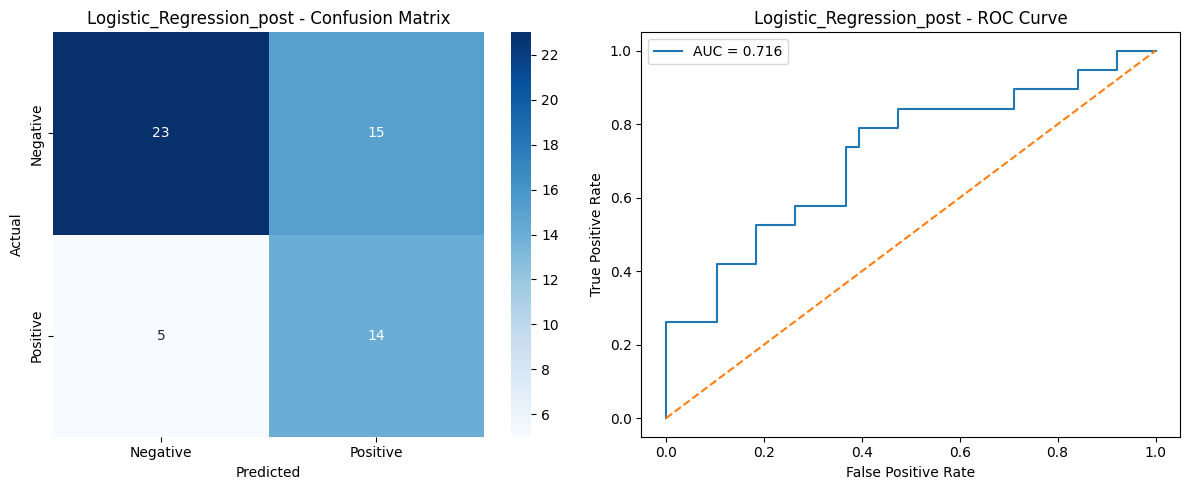

{'name': 'Logistic_Regression_post',
 'model': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                     max_iter=5000, penalty='elasticnet',
                                     solver='saga'))]),
 'prob': array([0.43817851, 0.04785015, 0.27280893, 0.33947386, 0.52339663,
        0.39883684, 0.15318948, 0.10746487, 0.73383971, 0.80586103,
        0.27027334, 0.42729992, 0.05703614, 0.73388503, 0.38133222,
        0.74622546, 0.87201692, 0.45881578, 0.22511841, 0.31142914,
        0.20323692, 0.24558957, 0.68858257, 0.15418731, 0.75948578,
        0.58747717, 0.3622305 , 0.70107259, 0.99545296, 0.82949441,
        0.84295945, 0.77215137, 0.13794142, 0.33121833, 0.39004589,
        0.58253483, 0.51322813, 0.68808993, 0.74750856, 0.35072162,
        0.80295321, 0.75640096, 0.0616247 , 0.21806947, 0.51123142,
        0.21184974, 0.28419907, 0.51870864, 0.97881954, 

In [ ]:
evaluate_model(
    'Logistic_Regression_post',
    log_reg,
    X_train_post,
    X_test_post,
    y_train_post,
    y_test_post,
    plot=True
)

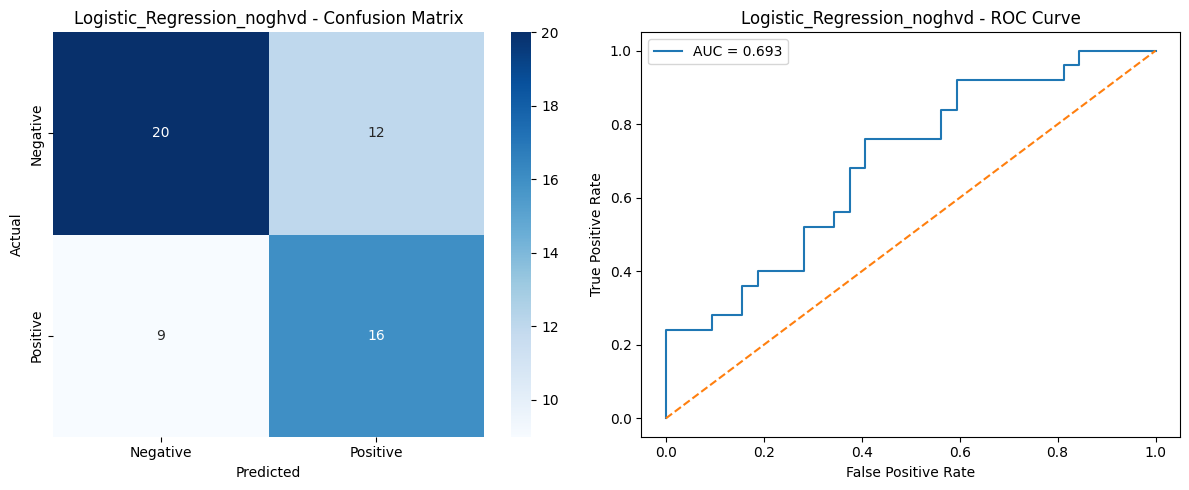

{'name': 'Logistic_Regression_noghvd',
 'model': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  LogisticRegression(class_weight='balanced', l1_ratio=0.5,
                                     max_iter=5000, penalty='elasticnet',
                                     solver='saga'))]),
 'prob': array([0.34833225, 0.6869351 , 0.44296021, 0.32455173, 0.58787573,
        0.81097986, 0.50368829, 0.49459243, 0.52662193, 0.96144315,
        0.58852443, 0.57441386, 0.47355662, 0.62882008, 0.28301974,
        0.29854154, 0.5821654 , 0.44786197, 0.32118872, 0.34310051,
        0.58853914, 0.16401651, 0.35499378, 0.49310038, 0.17911204,
        0.64246614, 0.94303187, 0.63438402, 0.32454147, 0.53494542,
        0.98626364, 0.70249603, 0.28264274, 0.60493977, 0.44219272,
        0.62844658, 0.19872935, 0.66929368, 0.50629326, 0.40577601,
        0.25362338, 0.29161843, 0.52283739, 0.37830237, 0.35508626,
        0.24704731, 0.35583734, 0.53955169, 0.32072551

In [ ]:
evaluate_model(
    'Logistic_Regression_noghvd',
    log_reg,
    X_train_nogvhd,
    X_test_nogvhd,
    y_train_nogvhd,
    y_test_nogvhd,
    plot=True
)

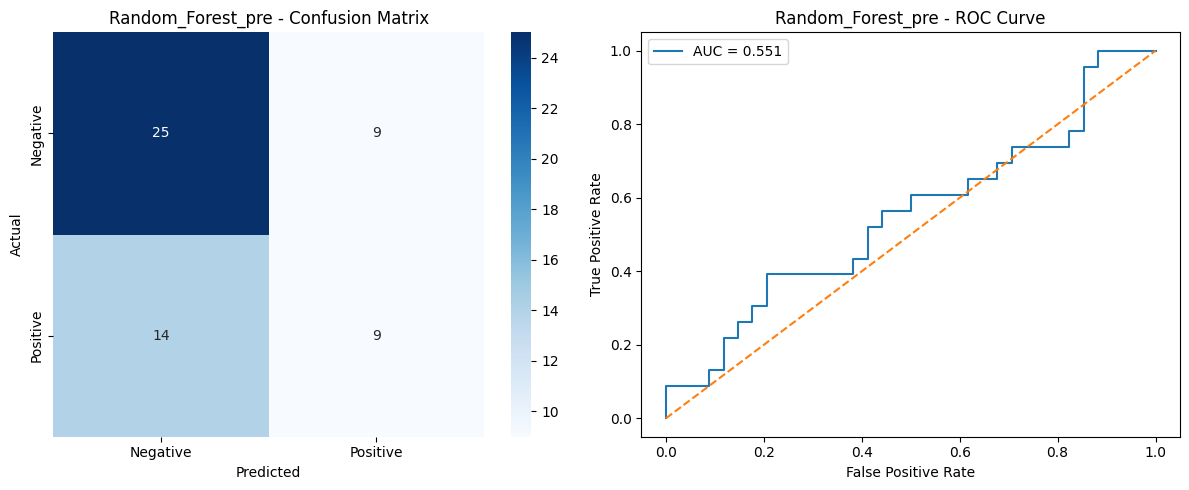

{'name': 'Random_Forest_pre',
 'model': RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                        n_estimators=500, random_state=42),
 'prob': array([0.28627754, 0.79812318, 0.41405501, 0.67239934, 0.61610602,
        0.39937644, 0.23140558, 0.39151239, 0.34356774, 0.65489918,
        0.3949859 , 0.44316072, 0.77574061, 0.43043861, 0.26914348,
        0.52021198, 0.65070007, 0.32304683, 0.6479044 , 0.17556118,
        0.45192151, 0.31784623, 0.23025876, 0.28453665, 0.49057404,
        0.49885381, 0.29457562, 0.47061777, 0.36584671, 0.40998688,
        0.39792332, 0.41941107, 0.33540185, 0.51445464, 0.54034771,
        0.49477192, 0.25837296, 0.39212519, 0.66028501, 0.752873  ,
        0.41802667, 0.40608562, 0.41117382, 0.71203387, 0.69773997,
        0.46158682, 0.55879735, 0.35893853, 0.70620137, 0.75465626,
        0.29236501, 0.47521164, 0.65843521, 0.43438902, 0.26748992,
        0.43539752, 0.36688374]),
 'pred': array([0, 1, 0, 1, 1, 0, 0, 0, 0,

In [ ]:
evaluate_model(
    'Random_Forest_pre',
    rf,
    X_train_pre,
    X_test_pre,
    y_train_pre,
    y_test_pre,
    plot=True
)

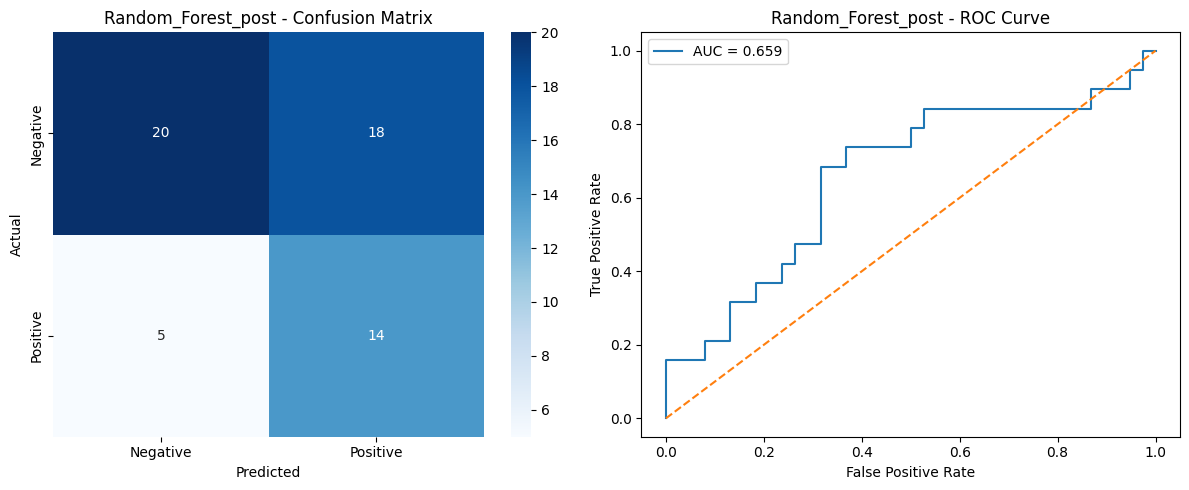

{'name': 'Random_Forest_post',
 'model': RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                        n_estimators=500, random_state=42),
 'prob': array([0.50853653, 0.27159587, 0.41831564, 0.41784402, 0.58125777,
        0.47240057, 0.38833486, 0.24035888, 0.59716002, 0.74166286,
        0.54756974, 0.50546179, 0.22038064, 0.60900896, 0.53531472,
        0.77331657, 0.61794289, 0.40320516, 0.36924349, 0.32811935,
        0.28549581, 0.56062186, 0.53668197, 0.25701529, 0.62336101,
        0.46316403, 0.27370967, 0.67079054, 0.83255571, 0.68223697,
        0.65027933, 0.55217247, 0.41659439, 0.3581854 , 0.50401731,
        0.49133819, 0.27708809, 0.51679889, 0.6311446 , 0.28359595,
        0.53587582, 0.6487547 , 0.36124963, 0.26586723, 0.43031261,
        0.3196784 , 0.4299082 , 0.59698054, 0.56186332, 0.71779705,
        0.26286361, 0.6163145 , 0.51778938, 0.66512015, 0.6330461 ,
        0.53497473, 0.54692119]),
 'pred': array([1, 0, 0, 0, 1, 0, 0, 0, 1

In [ ]:
evaluate_model(
    'Random_Forest_post',
    rf,
    X_train_post,
    X_test_post,
    y_train_post,
    y_test_post,
    plot=True
)

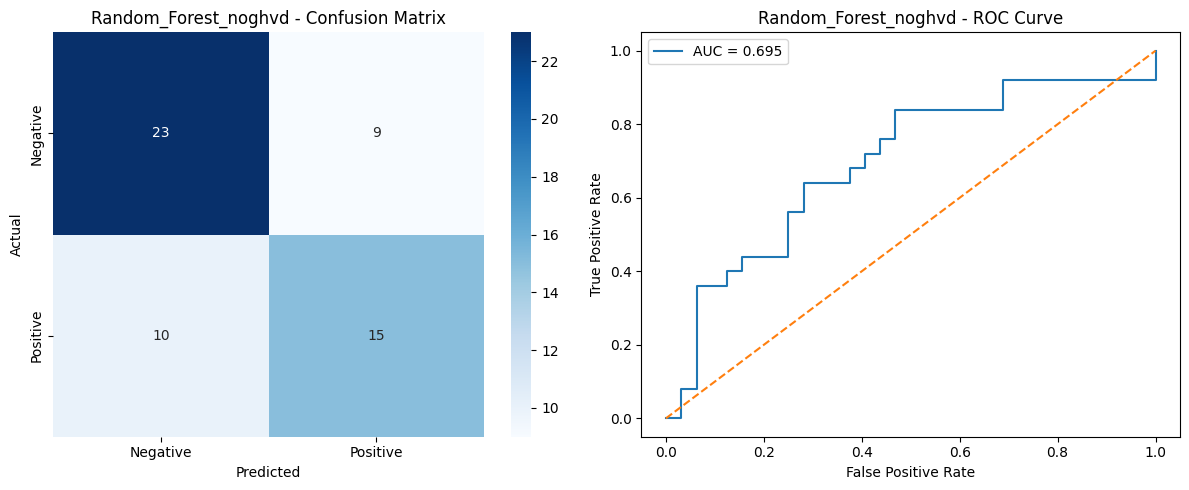

{'name': 'Random_Forest_noghvd',
 'model': RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                        n_estimators=500, random_state=42),
 'prob': array([0.48022896, 0.52954772, 0.41367691, 0.31602662, 0.53158819,
        0.65336009, 0.64021176, 0.41773214, 0.47248377, 0.63303926,
        0.50743468, 0.53136527, 0.41522404, 0.54015439, 0.23019458,
        0.37809441, 0.5520873 , 0.4574172 , 0.39650789, 0.57055511,
        0.651102  , 0.36162005, 0.26865191, 0.40302507, 0.34201281,
        0.81736332, 0.74519641, 0.56380416, 0.39535434, 0.53585767,
        0.64183349, 0.64487265, 0.28869912, 0.45437145, 0.43256689,
        0.47818192, 0.34498802, 0.68862799, 0.50625258, 0.4187786 ,
        0.38286337, 0.34218084, 0.45869305, 0.40382419, 0.371578  ,
        0.39930514, 0.39529116, 0.50986165, 0.32368178, 0.7597236 ,
        0.54654053, 0.39650415, 0.3368929 , 0.63035376, 0.47418796,
        0.65652042, 0.43144449]),
 'pred': array([0, 1, 0, 0, 1, 1, 1, 0,

In [ ]:
evaluate_model(
    'Random_Forest_noghvd',
    rf,
    X_train_nogvhd,
    X_test_nogvhd,
    y_train_nogvhd,
    y_test_nogvhd,
    plot=True
)

In [ ]:
def repeated_cv_metrics(model, X, y, cv):
    aucs, acc, briers = [], [], []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        prob = model.predict_proba(X_test)[:, 1]

        aucs.append(roc_auc_score(y_test, prob))
        acc.append(accuracy_score(y_test, model.predict(X_test)))
        briers.append(brier_score_loss(y_test, prob))

    return {
        "AUC_mean": np.mean(aucs),
        "AUC_std": np.std(aucs),
        "Accuracy": np.mean(acc),
        "Brier": np.mean(briers)
    }


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=10,
    random_state=42
)


In [ ]:
from sklearn.metrics import brier_score_loss

In [ ]:
X_pre = df_model[PRE_TX]

pre_lr = repeated_cv_metrics(log_reg, X_pre, y, cv)
pre_rf = repeated_cv_metrics(rf, X_pre, y, cv)

pre_lr, pre_rf


({'AUC_mean': np.float64(0.5894509803921569),
  'AUC_std': np.float64(0.0827041352155354),
  'Accuracy': np.float64(0.5606116642958748),
  'Brier': np.float64(0.25165455861307895)},
 {'AUC_mean': np.float64(0.5793389355742297),
  'AUC_std': np.float64(0.07362745625547137),
  'Accuracy': np.float64(0.552958748221906),
  'Brier': np.float64(0.25005859063392427)})

In [ ]:
X_post = df_model[POST_TX_FULL]

post_lr = repeated_cv_metrics(log_reg, X_post, y, cv)
post_rf = repeated_cv_metrics(rf, X_post, y, cv)

post_lr, post_rf


({'AUC_mean': np.float64(0.6943725490196077),
  'AUC_std': np.float64(0.08842675279779187),
  'Accuracy': np.float64(0.6284068278805122),
  'Brier': np.float64(0.22611565218988303)},
 {'AUC_mean': np.float64(0.6505994397759105),
  'AUC_std': np.float64(0.09552164101700013),
  'Accuracy': np.float64(0.5986486486486486),
  'Brier': np.float64(0.2323513663653144)})

In [ ]:
X_no_gvhd = df_model[POST_TX_NO_GVHD]
post_nogvhd_rf = repeated_cv_metrics(rf, X_no_gvhd, y, cv)
post_nogvhd_lr = repeated_cv_metrics(log_reg, X_no_gvhd, y, cv)

post_nogvhd_lr, post_nogvhd_rf


({'AUC_mean': np.float64(0.673627450980392),
  'AUC_std': np.float64(0.08707030596906806),
  'Accuracy': np.float64(0.6022048364153627),
  'Brier': np.float64(0.227133581553339)},
 {'AUC_mean': np.float64(0.6434817927170868),
  'AUC_std': np.float64(0.08957460359136009),
  'Accuracy': np.float64(0.6013798008534851),
  'Brier': np.float64(0.2329583208268825)})

In [ ]:
def bootstrap_auc(model, X_train, y_train, X_test, y_test, n_boot=1000):
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    aucs = []

    for _ in range(n_boot):
        # Correctly generate indices based on the length of the test set
        idx = np.random.choice(len(y_test), len(y_test), replace=True)
        aucs.append(roc_auc_score(y_test[idx], probs[idx]))

    return np.percentile(aucs, [2.5, 97.5])

rf_ci = bootstrap_auc(rf, X_train_post, y_train_post, X_test_post, y_test_post)
rf_ci

array([0.48626735, 0.81948583])

In [ ]:
bootstrap_auc(rf, X_train_nogvhd, y_train_nogvhd, X_test_nogvhd, y_test_nogvhd)

array([0.55084677, 0.8237828 ])

In [ ]:
bootstrap_auc(rf, X_train_pre, y_train_pre, X_test_pre, y_test_pre)

array([0.4071863 , 0.69894111])

PermutationExplainer explainer: 188it [04:06,  1.35s/it]
/tmp/ipython-input-3027631590.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


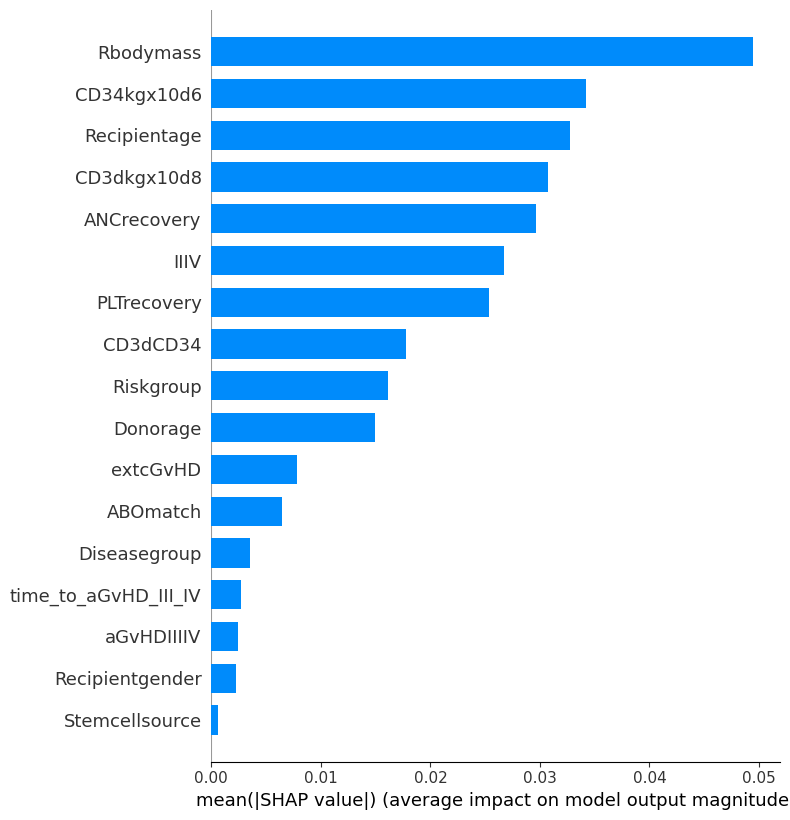

In [ ]:
# Define a function that returns the probability of the positive class
def predict_proba_positive_class(X):
    return rf.predict_proba(X)[:, 1]

# Re-fit the Random Forest model on the POST_TX_FULL training data
# This ensures the model is aligned with the features used in X_post for SHAP calculation
rf.fit(X_train_post, y_train_post)

# Use shap.Explainer with the prediction function and X_post as the background dataset
# This creates a more general explainer that will correctly produce SHAP values
# for the single output (positive class probability) across all features.
explainer = shap.Explainer(predict_proba_positive_class, X_post)

# Calculate SHAP values for X_post
shap_values = explainer(X_post).values

shap.summary_plot(
    shap_values,
    X_post,
    plot_type="bar"
)

<Axes: xlabel='timeline'>

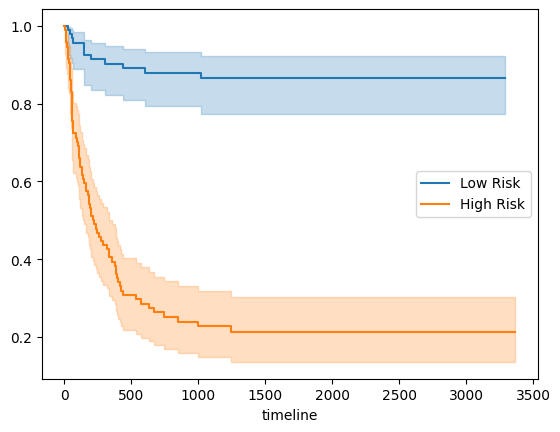

In [ ]:
risk = rf.predict_proba(X_post)[:,1]
median_risk = np.median(risk)

high = risk >= median_risk
low = risk < median_risk

kmf = KaplanMeierFitter()
kmf.fit(time[low], y[low], label="Low Risk")
ax = kmf.plot()

kmf.fit(time[high], y[high], label="High Risk")
kmf.plot(ax=ax)


In [ ]:
logrank_test(
    time[low], time[high],
    event_observed_A=y[low],
    event_observed_B=y[high]
).p_value


np.float64(8.45203899222145e-20)

In [ ]:
from lifelines import CoxPHFitter

cox_df = df_model[POST_TX_FULL].copy()
cox_df["time"] = time
cox_df["event"] = y

cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_df, duration_col="time", event_col="event")

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 187 total observations, 102 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 187
number of events observed = 85
   partial log-likelihood = -382.90
         time fit was run = 2026-02-04 16:38:41 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Recipientage          0.02      1.02      0.03           -0.04            0.07                0.96                1.07
Recipientgender       0.02      1.02      0.21           -0.39            0.44                0.68                1.56
Rbodymass             0.01      1.01      0.01           -0.01            0.02                0.99                1.02
Diseasegroup         -0.04      0.96      0.30           -0.63            0.54                0.53                1.71
Riskgroup             0.31      1.36      0.21           -0.10            0.72                0.90                2.05
ABOmatch             -0.11      0.90      0.22           -0.54            0.32                0.58                1.38
Donorage              0.02      1.02      0.01           -0.01            0.04                0.99                1.04
Stemcellsource       -0.12      0.89      0.27           -0.65            0.42                0.52                1.52
CD34kgx10d6           0.00      1.00      0.01           -0.02            0.03                0.98                1.03
ANCrecovery           0.00      1.00      0.00            0.00            0.00                1.00                1.00
PLTrecovery           0.00      1.00      0.00            0.00            0.00                1.00                1.00
CD3dkgx10d8          -0.05      0.95      0.04           -0.12            0.02                0.89                1.02
CD3dCD34              0.00      1.00      0.01           -0.02            0.02                0.98                1.02
IIIV                  0.12      1.13      0.23           -0.33            0.58                0.72                1.78
aGvHDIIIIV           -0.30      0.74      0.41           -1.10            0.49                0.33                1.63
extcGvHD             -0.20      0.82      0.26           -0.72            0.32                0.49                1.37
time_to_aGvHD_III_IV -0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                      cmp to     z      p  -log2(p)
covariate                                          
Recipientage            0.00  0.53   0.59      0.75
Recipientgender         0.00  0.12   0.91      0.14
Rbodymass               0.00  0.94   0.35      1.53
Diseasegroup            0.00 -0.15   0.88      0.18
Riskgroup               0.00  1.47   0.14      2.82
ABOmatch                0.00 -0.50   0.62      0.70
Donorage                0.00  1.32   0.19      2.41
Stemcellsource          0.00 -0.43   0.67      0.59
CD34kgx10d6             0.00  0.28   0.78      0.37
ANCrecovery             0.00  4.00 <0.005     13.97
PLTrecovery             0.00  5.69 <0.005     26.22
CD3dkgx10d8             0.00 -1.31   0.19      2.40
CD3dCD34                0.00  0.42   0.67      0.57
IIIV                    0.00  0.52   0.60      0.73
aGvHDIIIIV              0.00 -0.75   0.45      1.15
extcGvHD                0.00 -0.76   0.45      1.16
time_to_aGvHD_III_IV    0.00 -0.33   0.74      0.43
---
Concordance = 0.74
Partial AIC = 799.80
log-likelihood ratio test = 73.70 on 17 df
-log2(p) of ll-ratio test = 27.60

In [ ]:
!pip install scikit-survival


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

y_surv = Surv.from_arrays(event=y.astype(bool), time=time)

rsf = RandomSurvivalForest(
    n_estimators=500,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42
)

rsf.fit(X_post, y_surv)


RandomSurvivalForest(min_samples_leaf=5, n_estimators=500, random_state=42)

In [ ]:
from sksurv.metrics import concordance_index_censored

cindex = concordance_index_censored(
    y.astype(bool),
    time,
    rsf.predict(X_post)
)[0]

cindex


np.float64(0.8857142857142857)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

cal_rf = CalibratedClassifierCV(
    rf,
    method="isotonic",
    cv=5
)

cal_rf.fit(X_post, y)


ImportError: cannot import name '_half_multinomial_loss' from 'sklearn.utils._array_api' (/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py)

In [ ]:
from sklearn.calibration import calibration_curve

prob_uncal = rf.predict_proba(X_post)[:,1]
prob_cal = cal_rf.predict_proba(X_post)[:,1]

frac_pos_u, mean_pred_u = calibration_curve(y, prob_uncal, n_bins=10)
frac_pos_c, mean_pred_c = calibration_curve(y, prob_cal, n_bins=10)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_pred_u, y=frac_pos_u,
    mode="markers+lines", name="Uncalibrated RF"
))

fig.add_trace(go.Scatter(
    x=mean_pred_c, y=frac_pos_c,
    mode="markers+lines", name="Calibrated RF"
))

fig.add_trace(go.Scatter(
    x=[0,1], y=[0,1], mode="lines", name="Perfect Calibration"
))

fig.update_layout(
    title="Calibration Curves (Post-Transplant Model)",
    xaxis_title="Mean Predicted Risk",
    yaxis_title="Observed Event Rate"
)

fig.show()


In [ ]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        mask = (y_prob > bins[i]) & (y_prob <= bins[i+1])
        if mask.sum() > 0:
            acc = y_true[mask].mean()
            conf = y_prob[mask].mean()
            ece += (mask.sum() / len(y_true)) * abs(acc - conf)
    return ece

ece_uncal = expected_calibration_error(y, prob_uncal)
ece_cal = expected_calibration_error(y, prob_cal)

ece_uncal, ece_cal


In [ ]:
def decision_curve(y_true, y_prob, thresholds):
    net_benefit = []
    n = len(y_true)

    for t in thresholds:
        tp = ((y_prob >= t) & (y_true == 1)).sum()
        fp = ((y_prob >= t) & (y_true == 0)).sum()
        nb = (tp / n) - (fp / n) * (t / (1 - t))
        net_benefit.append(nb)

    return net_benefit

thresholds = np.linspace(0.05, 0.5, 20)

nb_model = decision_curve(y, prob_cal, thresholds)
nb_all = y.mean() - (1 - y.mean()) * (thresholds / (1 - thresholds))
nb_none = np.zeros_like(thresholds)

fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=nb_model, name="Calibrated Model"))
fig.add_trace(go.Scatter(x=thresholds, y=nb_all, name="Treat All"))
fig.add_trace(go.Scatter(x=thresholds, y=nb_none, name="Treat None"))

fig.update_layout(
    title="Decision Curve Analysis",
    xaxis_title="Threshold Probability",
    yaxis_title="Net Benefit"
)

fig.show()


In [ ]:
rf.fit(X_pre, y)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=500, random_state=42)

<Axes: xlabel='timeline'>

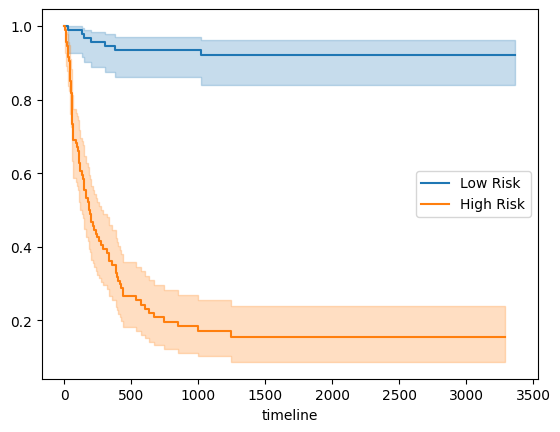

In [ ]:
risk = rf.predict_proba(X_pre)[:,1]
median_risk = np.median(risk)

high = risk >= median_risk
low = risk < median_risk

kmf = KaplanMeierFitter()
kmf.fit(time[low], y[low], label="Low Risk")
ax = kmf.plot()

kmf.fit(time[high], y[high], label="High Risk")
kmf.plot(ax=ax)
